# Explaining Feature Importance by example of a Random Forest

In many (business) cases it is equally important to not only have an accurate, but also an interpretable model. Oftentimes, apart from wanting to know what our model's house price prediction is, we also wonder why it is this high/low and which features are most important in determining the forecast Another example might be predicting customer churn - it is very nice to have a model that is successfully predicting which customers are prone to churn, but identifying which variables are important can help us in early detection and maybe even improving the product/service!

Knowing feature importance indicated by machine learning models can benefit you in multiple ways, here are some examples:
* by getting a better understanding of the model's logic you can not only verify it being correct, but also work on improving the model by focusing only on the important variables
* the above can be used for variable selection - you can remove x variables that are not that significant and have similar or better performance in much shorter training time
* in some business cases it makes sense to sacrifice some accuracy for the sake of interpretability. For example, when a bank rejects a loan application, it must also have a reasoning behind the decision, which can also be presented to the customer

That is why in this article I would like to explore different approaches to interpreting feature importance by example of a Random Forest model. Most of them are also applicable to different models, starting from linear regression and ending with black-boxes such as XGBoost.

One thing to note is that the more accurate our model is, the more we can trust feature importance measures and other interpretations. I assume that the model we build is reasonably accurate (as each data scientist will strive to have such a model) and in this article I focus on importance measures.

## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})


I define a few helper functions to make analysis more convenient and presentable.

In [2]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

## Loading data

For this example I will use the Boston house prices dataset (so a regression problem). But the approaches described in this article work just as well with classification problems, the only difference is the metric used for evaluation.

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

The only non-standard thing in preparing the data is the addition of a random column to the dataset. Logically, it has no predictive power over the dependent variable (Median value of owner-occupied homes in $1000's), so it should not be an important feature in the model. Let's see how it will turn out.

In [4]:
y = boston.target
X = pd.DataFrame(boston.data, columns = boston.feature_names)
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

Below I inspect the relationship between the random feature and the target variable. As it can be observed, there is no pattern on the scatterplot and the correlation is almost 0.

Text(0.5, 1.0, 'Random feature vs. target variable')

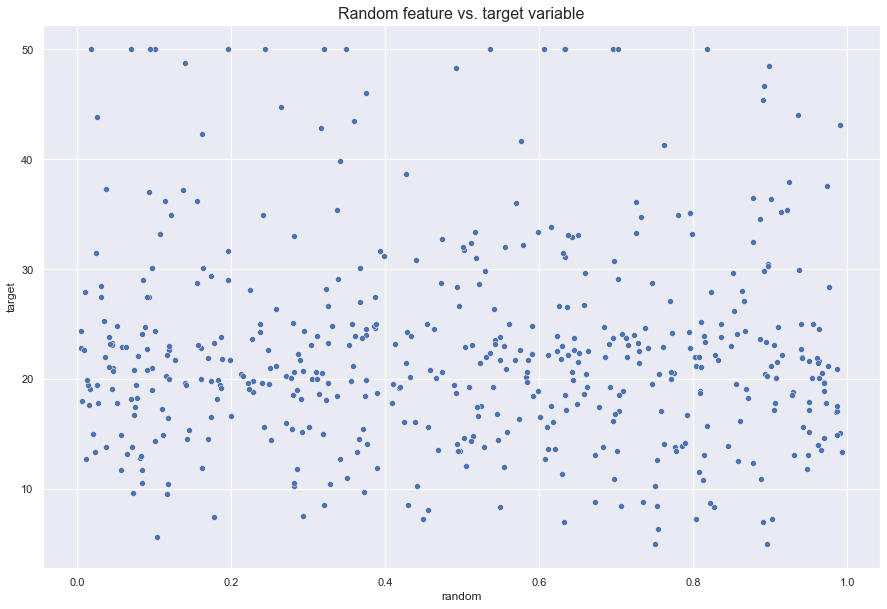

In [5]:
sns.scatterplot(x = 'random', y = 'target', data = X.assign(target = y)).set_title('Random feature vs. target variable', fontsize = 16)

Text(0.5, 1.0, 'Correlation matrix')

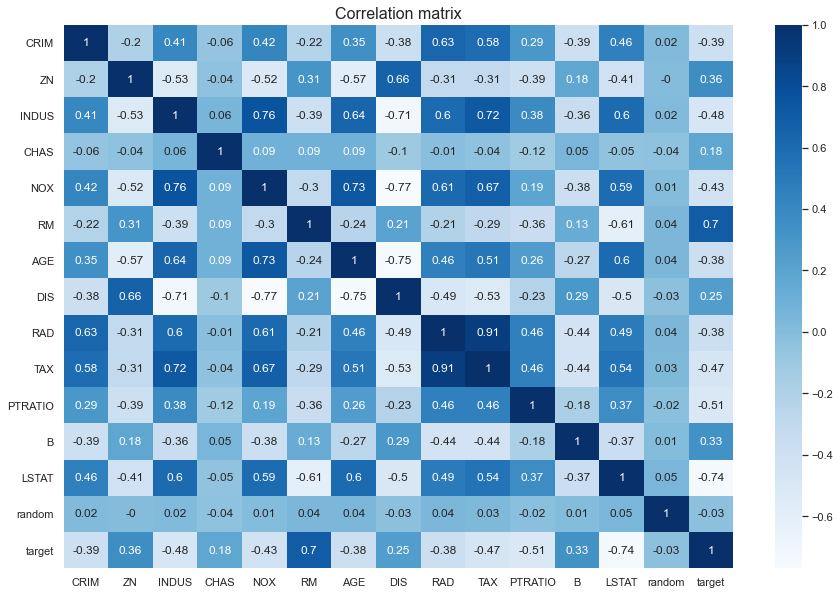

In [6]:
sns.heatmap(X.assign(target = y).corr().round(2), cmap = 'Blues', annot = True).set_title('Correlation matrix', fontsize = 16)

One thing to note here is that there is not much sense in interpreting the correlation for `CHAS`, as it is a binary variable and different methods should be used for it.

## Benchmark model

I train a plain Random Forest model to have a benchmark. I set a `random_state` to ensure results comparability. I also use bootstrap and set `oob_score = True` to later use the out-of-bag error. 

Briefly, each tree in the random forest is trained on a different dataset, sampled with replacement from the original data. This results in around ~2/3 of distinct observations in each training set. The out-of-bag error is calculated on all the observations, but for calculating each row's error the model only considers trees which have not seen this row during training. This is similar to evaluating the model on a validation set. You can read more [here](https://stackoverflow.com/questions/18541923/what-is-out-of-bag-error-in-random-forests).

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [8]:
print(f"""R^2 Training Score: {rf.score(X_train, y_train):.2f}
OOB Score: {rf.oob_score_:.2f}
R^2 Validation Score: {rf.score(X_valid, y_valid):.2f}""")

R^2 Training Score: 0.98
OOB Score: 0.83
R^2 Validation Score: 0.88


Well, there is some overfitting in the model, as it performs much worse on OOB sample and worse on the validation set. But let's say it is good enough and move forward to feature importances (measured on the training set performance). Some of the approaches can also be used for validation/OOB sets, to gain further interpretability on the unseen data.

## Overall feature importances

By overall feature importances I mean the ones derived at model level, i.e., saying that in a given model these features are most important in explaining the target variable.

### Default Scikit-learn's feature importances

Let's start with decision trees to build some intuition. In decision trees, every node is a condition how to split values in a single feature, so that similar values of dependent variable end up in the same set after the split. The condition is based on impurity, which in case of classification problems is Gini impurity / information gain (entropy), while for regression trees its variance. So when training a tree we can compute how much each feature contributes to decreasing the weighted impurity. `feature_importances_` in Scikit-Learn is based on that logic, but in case of Random Forest we are talking about averaging the decrease in impurity over trees.

Pros:
* fast calculation 
* easy to retrieve - one command

Cons:
* biased approach, as it has a tendency to inflate the importance of continuous features or high-cardinality categorical variables

In [9]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

,feature,feature_importance
0,RM,0.502039
1,LSTAT,0.309240
2,DIS,0.059712
3,CRIM,0.036277
4,PTRATIO,0.016545
5,TAX,0.014164
6,NOX,0.013362
7,AGE,0.012777
8,B,0.011106
9,random,0.009482


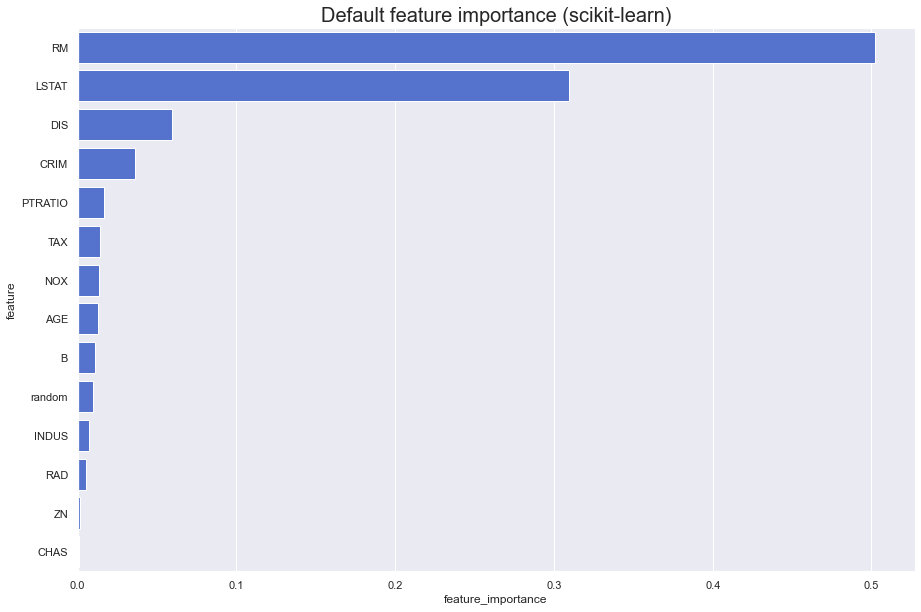

In [10]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

It seems that the top 3 most important features are:
* average number of rooms   
* % lower status of the population
* weighted distances to five Boston employment centres

What seems surprising though is that a column of random values turned out to be more important than:
* proportion of non-retail business acres per town
* index of accessibility to radial highways
* proportion of residential land zoned for lots over 25,000 sq.ft.
* Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

Intuitively this feature should have zero importance on the target variable. Let's see how it is evaluated by different approaches.

### Permutation feature importance

This approach directly measures feature importance by observing how random re-shuffling (thus preserving the distribution of the variable) of each predictor influences model performance. 

The approach can be described in the following steps:
1. Train the baseline model and record the score (accuracy/R^2/any metric of importance) by passing validation set (or OOB set in case of Random Forest). This can also be done on the training set, at the cost of sacrificing information about generalisation.
2. Re-shuffle values from one feature in the selected dataset, pass the dataset to the model again to obtain predictions and calculate the metric for this modified dataset. The feature importance is the difference between the benchmark score and the one from the modified (permuted) dataset.
3. Repeat 2. for all feature in the dataset.

Pros:
* applicable to any model
* reasonably efficient 
* reliable technique
* no need to retrain the model at each modification of the dataset

Cons:
* more computationally expensive than default `feature_importances`
* permutation importance overestimates the importance of correlated predictors - Strobl *et al* (2008)

As for the second problem with this method, I have already plotted the correlation matrix above. However, I will use a function from one of the libraries I use to visualise Spearman's correlations. The difference between standard Pearson's correlation is that this one first transforms variables into ranks and only then runs Pearson's correlation on the ranks.

Spearman's correlation:
* is nonparametric
* does not assume linear relationship between variables
* it looks for monotonic relationships. 

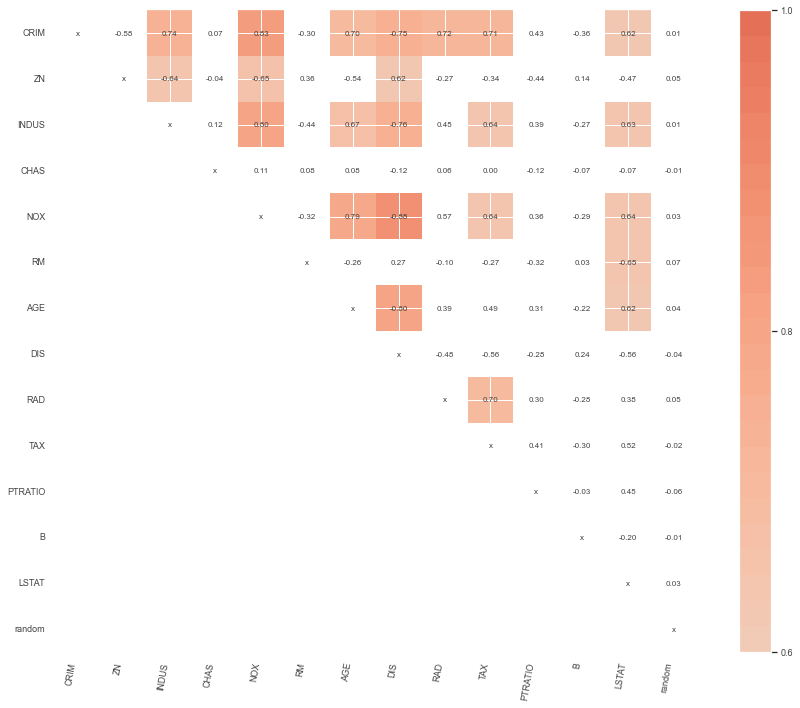

In [11]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(15,10))
viz.view()

I found two libraries with this functionality, not that it is difficult to code it. Let's go over both of them as they have some unique features.

#### rfpimp

One thing to note about this library is that we have to provide a metric as a function of the form `metric(model, X, y)`. This way we can use more advanced approaches such as using the OOB score of Random Forest. This library already contains functions for that (`oob_regression_r2_score`). But to keep the approach uniform, I will calculate the metrics on the training set (losing information about generalisation).

In [12]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

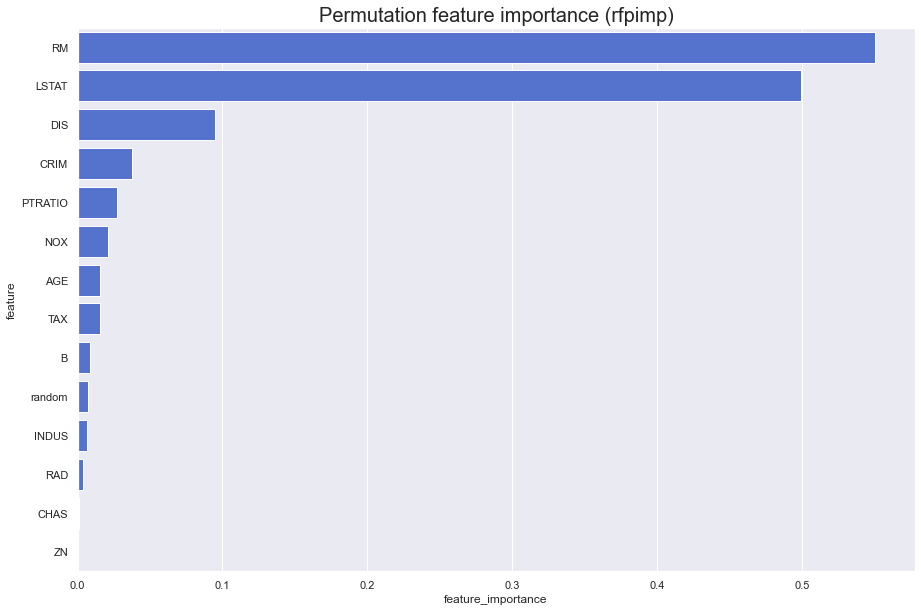

In [13]:
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

The plot confirms what we have seen above, that 4 variables are less important than a random variable! Surprising... The top 4 stayed the same though. One more nice feature about `rfpimp` is that it contains functionalities for dealing with the issue of collinear features (that was the idea behind showing the Spearman's correlation matrix). For brevity I will not show this case here, but you can read more in this great [article](https://explained.ai/rf-importance/index.html#5) by the authors of the library. 

#### eli5

There are a few differences from the basic approach of `rfpimp` and the one employed in `eli5`. 
Some of them are:
* there are parameters `cv` and `refit` connected to using cross-validation. In this example I set them to `None`, as I do not use it but it might come in handy in some cases.
* there is a `metric` parameter, which as in `rfpimp` accepts a function in the form of `metric(model, X, y)`. If this parameter is not specified, the function will use the default `score` method of the estimator.
* `n_iter` - number of random shuffle iterations, the end score is the average    

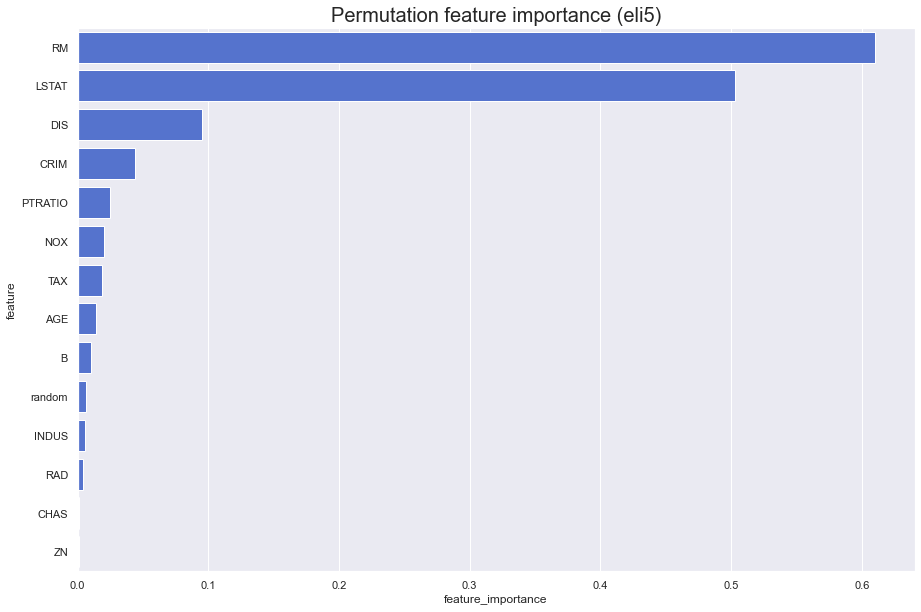

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

The results are very similar to the previous ones, even as these came from multiple reshuffles per column.

The default importance DataFrame is not the most readable, as it does not contain variable names. This can be of course quite easily fixed. The nice thing is the standard error from all iterations of the reshuffling on each variable.

In [15]:
eli5.show_weights(perm)

Weight,Feature
0.6099 ± 0.0724,x5
0.5031 ± 0.0989,x12
0.0951 ± 0.0248,x7
0.0441 ± 0.0064,x0
0.0244 ± 0.0073,x10
0.0205 ± 0.0041,x4
0.0185 ± 0.0042,x9
0.0144 ± 0.0027,x6
0.0102 ± 0.0016,x11
0.0064 ± 0.0015,x13


One extra nice thing about `eli5` is that it is really easy to use the results of permutation approach to carry out feature selection by using Scikit-learn's `SelectFromModel` or `RFE`.

### Drop Column feature importance

This approach is quite an intuitive one, as we investigate the importance of a feature by comparing a model with all features versus a model with this feature dropped for training.

I created a function (based on `rfpimp`'s implementation) for this approach below, which shows the underlying logic.

Pros:
* most accurate feature importance 

Cons:
* potentially high computation cost due to retraining the model for each variant of the dataset (after dropping a single feature column)

In [16]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

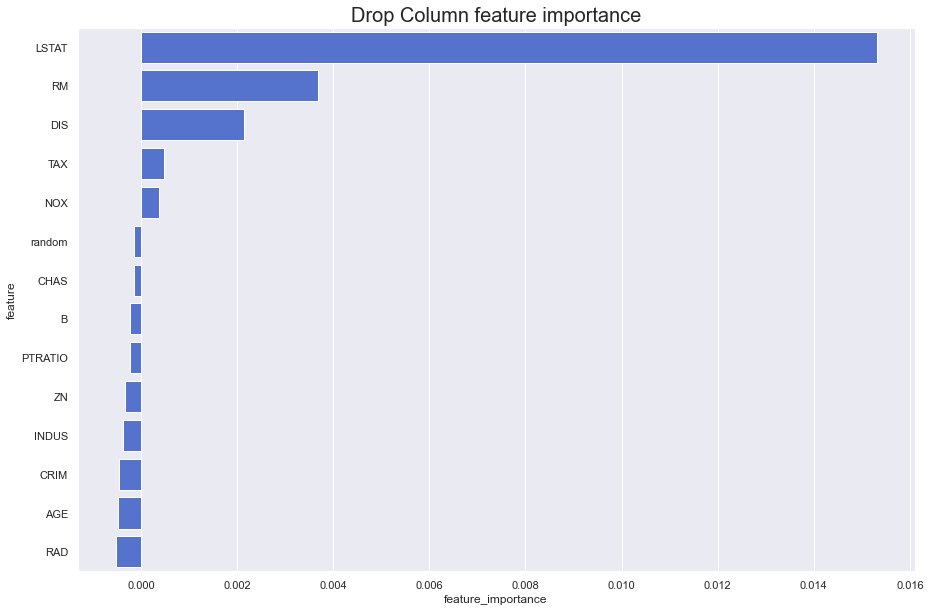

In [17]:
drop_imp = drop_col_feat_imp(rf, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column feature importance')

Here it gets interesting. First of all, negative importance in this case means that removing a given feature from the model actually improves the performance. So this is nice to see in case of `random`.

## Observation level feature importance

By observation level feature importances I mean ones that had most impact on explaining a particular observation fed to the model. For example, in case of credit scoring, we would be able to say that these features had most impact on determining client's credit score.

### Treeinterpreter

The main idea of `treeinterpreter` is that it uses the underlying trees in Random Forest to explain how each feature contributes the end value. We can observe how the value of the prediction (defined as the sum of each feature contributions + average given by the initial node that is based on the entire training set) changes along the prediction path within the decision tree (after every split), together with the information which feature caused the split (so also the change in prediction).

The formula for the prediction function ($f(x)$) can be written down as:
$$ f(x) = c_{full} +\sum_{k=1}^{K}contribution(x, k)$$

where $c_{full}$ is the average of the entire dataset (initial node), $K$ is the total number of features.

This may sound complicated, but take a look at an example from the author of the library:

In [18]:
%%html
<img src="img/dec_tree.png",width=40,height=40>

As Random Forest's prediction is the average of the trees, the formula for average prediction is the following:

$$F(x) = \frac{1}{J} \sum_{j=1}^{J} c_{j_{full}} + \sum_{k=1}^{K}(\frac{1}{J}\sum_{j=1}^{J}contribution_{j}(x,k))$$

where $J$ is the number of trees in the forest.

I start by identifying rows with lowest and highest absolute prediction error and will try to see what caused the difference.

In [19]:
pred_diff = pd.DataFrame({'difference': abs(y_train - rf.predict(X_train))})

print('Index with smallest error:', pred_diff.sort_values('difference').head(1).index.values[0])
print('Index with largest error:', pred_diff.sort_values('difference', ascending = False).head(1).index.values[0])

Index with smallest error: 5
Index with largest error: 135


Using `treeintrerpreter` I obtain 3 objects: predictions, bias (average value of the dataset) and contributions.

In [20]:
from treeinterpreter import treeinterpreter as ti, utils

selected_rows = [5, 135]
selected_df = X_train.iloc[selected_rows,:].values
prediction, bias, contributions = ti.predict(rf, selected_df)

For the observation with smallest error, the main contributor was `LSTAT` and `RM` (which in previous cases turned out to be most important variables). In the highest error case, the highest contribution came from `DIS` variable, overcoming the same two variables that played the most important role in the first case.

In [21]:
for i in range(len(selected_rows)):
    print("Row", selected_rows[i])
    print("Prediction:", prediction[i][0], 'Actual Value:', y_train[selected_rows[i]])
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20) 

Row 5
Prediction: 24.611000000000004 Actual Value: 24.6
Bias (trainset mean) 22.886769801980186
Feature contributions:
LSTAT 6.28
RM -4.05
DIS -0.42
TAX -0.19
CRIM 0.17
random -0.14
ZN 0.05
NOX 0.03
INDUS -0.03
AGE 0.02
CHAS -0.02
B 0.01
RAD -0.01
PTRATIO 0.01
--------------------
Row 135
Prediction: 30.461999999999996 Actual Value: 21.9
Bias (trainset mean) 22.886769801980186
Feature contributions:
RM 18.01
PTRATIO -3.8
CRIM -3.37
LSTAT 1.86
RAD -1.24
random -1.19
B -1.02
DIS -0.75
INDUS -0.49
NOX -0.19
CHAS -0.17
ZN -0.04
AGE -0.03
TAX -0.03
--------------------


To dive even deeper, we might also be interested in joined contribution of many variables (as explained in the case of XOR [here](http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/)). I will go right to the example, more information can be found under the link.

In [22]:
prediction1, bias1, contributions1 = ti.predict(rf, np.array([selected_df[0]]), joint_contribution=True)
prediction2, bias2, contributions2 = ti.predict(rf, np.array([selected_df[1]]), joint_contribution=True)

In [23]:
aggregated_contributions1 = utils.aggregated_contribution(contributions1)
aggregated_contributions2 = utils.aggregated_contribution(contributions2)

In [24]:
res = []
for k in set(aggregated_contributions1.keys()).union(
              set(aggregated_contributions2.keys())):
    res.append(([X_train.columns[index] for index in k] , 
               aggregated_contributions1.get(k, 0) - aggregated_contributions2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)

['RM'] [-17.56773897]
['RM', 'PTRATIO'] [2.92516221]
['CRIM', 'RM'] [2.09151363]
['CRIM', 'RM', 'LSTAT'] [1.07122974]
['RM', 'RAD'] [0.8985446]
['RM', 'DIS', 'LSTAT'] [-0.72166823]
['RM', 'DIS'] [0.6942177]
['RM', 'PTRATIO', 'LSTAT'] [0.65634401]
['RM', 'B'] [0.61382307]
['RM', 'random'] [0.42210476]


The most of the difference between the best and worst predicted cases comes from the number of rooms (`RM`) feature, in conjunction with weighted distances to five Boston employment centres (`DIS`).

### LIME

LIME (Local Interpretable Model-agnostic Explanations) is a technique explaining the predictions of any classifier/regressor in an interpretable and faithful manner. To do so, an explanation is obtained by locally approximating the selected model with an interpretable one (such as linear models with regularisation or decision trees). The interpretable models are trained on small perturbations (adding noise) of the original observation (row in case of tabular data), thus they only provide good local approximation. 

Some drawbacks to be aware of:
* only linear models are used to approximate local behaviour
* type of perturbations that need to be performed on the data to obtain correct explanations are often use-case specific
* simple (default) perturbations are often not enough. In an ideal case, the modifications would be driven by the variation that is observed in the dataset

In [25]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode = 'regression',
                                                   feature_names = X_train.columns,
                                                   categorical_features=[3], 
                                                   categorical_names=['CHAS'], 
                                                   discretize_continuous = True)

Below you can see the output of LIME interpretation. 

There are 3 parts of the output:
1. Predicted value
2. Feature importance - in case of regression it shows whether it has a negative or positive impact on the prediction, sorted by absolute impact descending. 
3. Actual values of these features for the explained rows.

Note that LIME has discretized the features in the explanation. This is because of setting `discretize_continuous=True` in the constructor above. The reason for discretization is that it gives continuous features more intuitive explanations.

In [26]:
np.random.seed(42)
exp = explainer.explain_instance(X_train.values[5], rf.predict, num_features=5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

np.random.seed(42)
exp = explainer.explain_instance(X_train.values[135], rf.predict, num_features=5)
exp.show_in_notebook(show_all=False)

LIME interpretation agrees that for these two observations the most important features are `RM` and `LSTAT`, which was also indicated by previous approaches.

## Conclusion

In this article I showed a few approaches to deriving feature importances from machine learning models (not limited to Random Forest). I believe that understanding results is often as much important as having good results, thus every data scientist should do his/her best to understand which variables are the most important for the model and why. Not only can this help getting a better business understanding, but also can lead to further improvements of the model.

## References

* [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
* [Conditional variable importance for random forests](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)
* [Interpreting random forests](http://blog.datadive.net/interpreting-random-forests/)
* [Random forest interpretation – conditional feature contributions](http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/)